# Linear Algebra Group Project
#### Group Members: Corey Dobbs and Emma Rasmussen 

### Problem 1
#### Part a: Write as a variational problem 
 
We are given the following for our boundary problem: 
$$ 
-u''(x) + V(x)u'(x) = f(x), x\epsilon [0,1]\\
u(0) = u(1) = 0\\
V(x) = \gamma, f(x) = 1\\
$$ 
We first start by picking a test function, $\phi(x)$. We then mupliply our initial function by this value and interate over x to get the following: 
$$ 
\quad -\int_{0}^{1} u''(x)\phi(x) \, dx + \int_{0}^{1} u'(x)V(x)\phi(x) \, dx = \int_{0}^{1} f(x)\phi(x) \, dx
$$
Focusing on the first term, we can use integration by parts to expand that to: 
$$
\left. -\phi \right|_{0}^{1} + \int_{0}^{1} u'(x)\phi'(x) \,dx 
$$
The first term of the above equation will go to zero, so getting rid of that and plugging our new expression back into our original intergral equation, we would end up with: 
$$
\quad \int_{0}^{1} u'(x)\phi'(x) \,dx + \int_{0}^{1} u'(x)V(x)\phi(x) \, dx = \int_{0}^{1} f(x)\phi(x) \, dx
$$ 
Where the terms, respecitvely, correspond to: 
$$ 
A_1[\phi(x),u(x)] + A_2[\phi(x),u(x)] = F[\phi(x)] 
$$ 

#### Part b: Expand u as a linear combination

Next, we will be expanding u as the given linear combination, $u = \sum_{i=1}^{m} u_i\phi_i(x)$. We will stop writing the x dependence of $\phi$ for simplicity, but note that it still exists. Also, we will assume that we are choosing $\phi$ from a finite dimensional basis $\{\phi_1, \phi_2, ...,\phi_m\}$:
$$
A_1[\phi_j,\sum_{i=1}^{m} u_i\phi_i] + A_2[\phi_j,\sum_{i=1}^{m} u_i\phi_i] = F[\phi_j] 
$$
Since $u_i$ is a scalar, we can pull that and the sum out and simplify to: 
$$ 
\sum_{i=1}^{m} u_i(A_1[\phi_j,\phi_i] + A_2[\phi_j,\phi_i]) = F[\phi_j] 
$$ 
In this expression, $u_i$ corresponds to $x$, $A_1[\phi_j,\phi_i] + A_2[\phi_j,\phi_i]$ corersponds to $A_{ij}$, and $F[\phi_j] $ corresponds to $b$, which shows that our problem is in the form $Ax-b$. 

#### Part c: Implement a driver routine that will return A and b given inputs n and gamma.  The matrix A should be implemented as a sparse representation in your environment.

In [19]:
from scipy.sparse import csr_matrix, diags
import numpy as np

def driver( n, gamma ):
    A2 = np.zeros( (n+1,n+1) )
    diagonalsA1 = np.ones( n ) * 2 * (n+1)
    off_diagonalsA1 = np.ones( n-1 ) * -(n+1)
    A1 = diags( [diagonalsA1,off_diagonalsA1,off_diagonalsA1], [0,1,-1], format="csr" )

    diagonalsA2 = np.zeros( n )
    upper_diags = np.ones( n ) * 0.5
    lower_diags = np.ones( n ) * -0.5
    A2 = gamma*diags( [diagonalsA2,upper_diags,lower_diags], [0,1,-1], format="csr" )
 
    A = A1 + A2
    b = np.ones( n ) / (n+1)
    return A, b, A1


In [20]:
from scipy.sparse import issparse
def mydot(A,M,vec):
    B = A @ M @ vec
    return B


def mygmres( I, b, x0, n, M, A ):

    # Initialize algorithm values
    r0 = b - mydot(A,M,x0)
    beta = np.linalg.norm( r0, 2 )

    v1 = (r0 / beta)
    v = np.zeros( (len(v1),n) )


    for i in range( len( v1 ) ):
        v[i,0] = v1[i]

    H = np.zeros( (n+1,n) )
    w = np.zeros((n,n))

    # Run Arnoldi algorithm
    for j in range( I ):
        w[:,j] = mydot(A,M,v[:,j])
        for i in range( j+1 ):
            H[i,j] = mydot( w[:,j], M, v[:,i])
            w[:,j] = w[:,j] - H[i,j] * v[:,i]
        H[j+1,j] = np.linalg.norm( w[:,j], 2 )
        if abs(H[j+1,j]) < 1e-8:
            break
        try:
            v[:,j+1] = w[:,j] / H[j+1,j]
        except:
            Exception('Did not converge')

    # Solve least squares problem
    e1 = np.zeros( (n+1,1) )
    e1[0] = 1
    y = np.linalg.lstsq( H, beta*e1, rcond = None )[0]
    x = v @ y + e1[:-1]

    res = np.linalg.norm(beta*e1 - H @ y, 2)/n

    return x, res

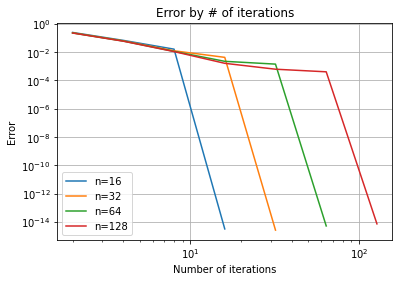

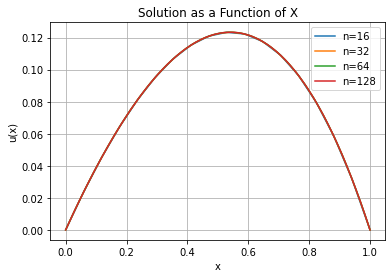

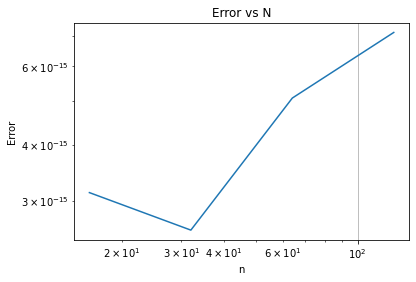

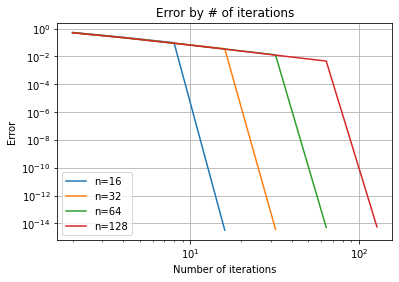

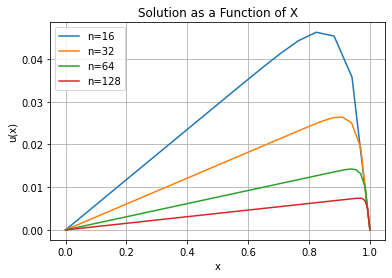

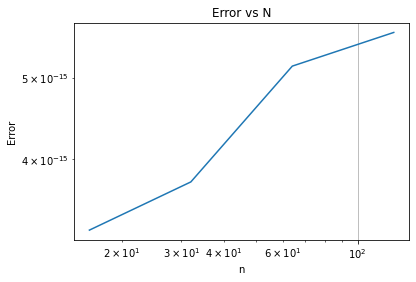

In [21]:
import matplotlib.pyplot as plt 

# Run mygmres and output graphs
def Graphing(gamma,v=None):
    # Iterate over n
    n = (16,32,64,128) 
    nerrvec = []
    for i in range(len(n)): 
        if v == 'n+1':
            gamma = n[i]+1
        # Initialize x0
        x0 = np.zeros(n[i])
        x0[0] = 1
        # Get A and b matrices
        A, b, _ = driver(n[i],gamma)
        # Initialize some iterative variables
        Ierrvec = []
        Ivec = []
        I = 2
        res = 1
        # Iterate until the error is less than 1E-6
        while res > 10**(-6):
            x,res = mygmres(I, b, x0, n[i], np.identity(n[i]), A )
            Ierrvec.append(res)
            Ivec.append(I)
            I *= 2 

        nerrvec.append(res)

        plt.figure(1)
        plt.loglog(Ivec, Ierrvec,label=f'n={n[i]}')
        # Enforce boundary conditions on solution
        xscale = np.linspace(0,1,n[i]+2)
        x = np.insert(x,0,0)
        x = np.append( x, 0)

        plt.figure(2)
        plt.plot(xscale,x,label=f'n={n[i]}')
        plt.title("Solution as a Function of X")

    plt.figure(3)
    plt.loglog(n, nerrvec)
    plt.title("Error vs N")

    plt.figure(1)
    plt.grid()
    plt.xlabel('Number of iterations')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Error by # of iterations')

    plt.figure(2)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()

    plt.figure(3)
    plt.grid()
    plt.xlabel('n')
    plt.ylabel('Error')
    plt.show()

Graphing(1,)
Graphing(1,'n+1')


#### Part c: Repeat problem 3 for the preconditioned version of the problem

Here, we solve the same problem, but with preconditioned matrices $\widetilde{A}$ and $\widetilde{b}$.


n=16
cond num A = 114.73204949231783
cond num A~ = 1.288489993376792
n=32
cond num A = 434.04697481125135
cond num A~ = 1.3093129191052681
n=64
cond num A = 1685.7630064506443
cond num A~ = 1.3204779573853807
n=128
cond num A = 6641.537110398958
cond num A~ = 1.3262649023287072


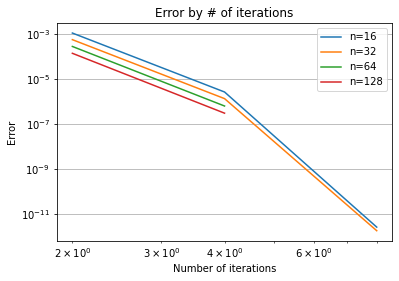

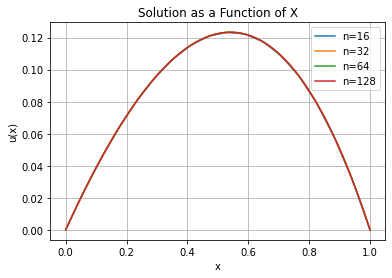

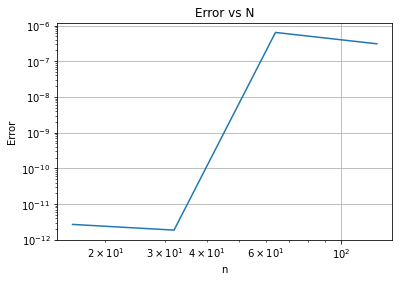

n=16
cond num A = 38.4364507786852
cond num A~ = 10.864578115770627
n=32
cond num A = 79.3595038127462
cond num A~ = 28.743599130135404
n=64
cond num A = 160.95099397047298
cond num A~ = 78.91958631206877
n=128
cond num A = 323.981354627762
cond num A~ = 220.15815979699875


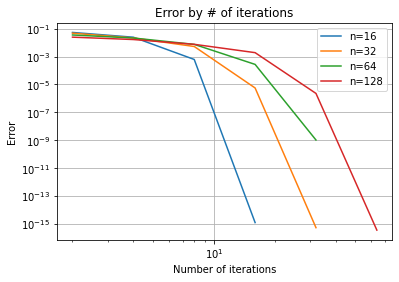

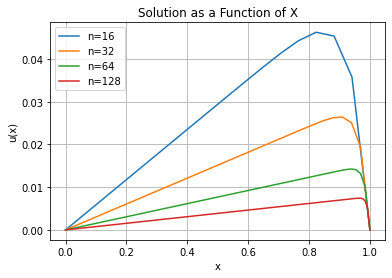

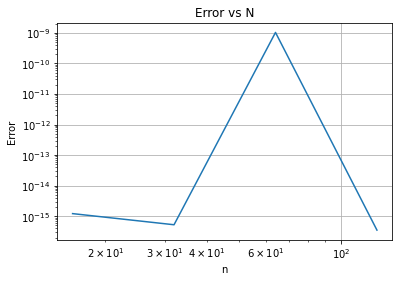

In [22]:
import matplotlib.pyplot as plt 
from scipy.sparse.linalg import inv
from scipy.sparse import csr_matrix, csc_matrix


# Run mygmres and output graphs
def GraphingPrecond(gamma,v=None):
    # Iterate over n
    n = (16,32,64,128) 
    nerrvec = []
    for i in range(len(n)): 
        if v == 'n+1':
            gamma = n[i]+1
        # Initialize x0
        x0 = np.zeros((n[i],1))
        x0[0]= 1
        # Get A and b matrices
        A, b, M = driver(n[i],gamma)
        b = csr_matrix( np.expand_dims(b,1) )
        # Print condition number
        print(f'n={n[i]}')
        print(f'cond num A = {np.linalg.cond(A.toarray())}')

        # Precondition matrices
        M = csc_matrix( M )
        Minv = inv(M)
        A = Minv @ A
        b = Minv @ b
        # Print condition number for comparison
        print(f'cond num A~ = {np.linalg.cond(A.toarray())}')
        # Initialize some iterative variables
        Ierrvec = []
        Ivec = []
        I = 2
        res = 1
        # Iteratively solve until error is less than 1E-6
        while res > 10**(-6):
            x,res = mygmres(I, b, x0, n[i], np.identity(n[i]), A )
            Ierrvec.append(res)
            Ivec.append(I)
            I *= 2 

        nerrvec.append(res)

        plt.figure(1)
        plt.loglog(Ivec, Ierrvec, label=f'n={n[i]}')
        
        # Enforce boundary conditions of solution
        xscale = np.linspace(0,1,n[i]+2)
        x = np.insert(x,0,0)
        x = np.append( x, 0)

        plt.figure(2)
        plt.plot(xscale,x,label=f'n={n[i]}')
        plt.title("Solution as a Function of X")
    plt.figure(3)
    plt.loglog(n, nerrvec)
    plt.title("Error vs N")
        
    plt.figure(1)
    plt.grid()
    plt.xlabel('Number of iterations')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Error by # of iterations')

    plt.figure(2)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()

    plt.figure(3)
    plt.grid()
    plt.xlabel('n')
    plt.ylabel('Error')
    plt.show()


GraphingPrecond(1,)
GraphingPrecond(1,'n+1')


#### Part d: Compare the convergence rates between the original problem and its preconditioned version.

Below is a table showing for which # of iterations the algorithm was able to converge.

|Case  | n=16 | n=32 | n=64 | n=128 |
|------|-----:|-----:|-----:|------:|
|$\gamma=1$|16    | 32   | 64   | 128   |
|$\gamma=n+1$|16    | 32   | 64   | 128   |
|$\gamma=1$, Preconditioned|8    | 8   | 4   | 4   |
|$\gamma=n+1$, Preconditioned|16    | 32   | 32   | 64   |

It is easy to see that the preconditioned matrices helped the algorithm converge to solutions faster than the original version.

We can also look at the condition numbers of the matrices for each case:
|Case  | n=16 | n=32 | n=64 | n=128 |
|------|-----:|-----:|-----:|------:|
|$\gamma=1$|114.73    | 434.05   | 1685.76   | 6641.54   |
|$\gamma=n+1$|38.44    | 79.36   | 160.95   | 323.98   |
|$\gamma=1$, Preconditioned|1.29    | 1.31   | 1.32   | 1.33   |
|$\gamma=n+1$, Preconditioned|10.86    | 28.74   | 78.92   | 220.16   |
